# Preamble

In [1]:
dir_home = '../'
dir_data = dir_home+'data/'
dir_fig = dir_home+'figs/'
import sys
sys.path.insert(0, dir_home)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from preamble import *
from natural_units_GeV import *

# Sensitivity

## Parameters

In [2]:
class Material:

    def __init__(self, R_S, R_M, Z_S, A_S, rho, N_c, N_S, V_c, S_sph, M_sph, S_def, M_def, P_nuc, etilde=1, Ptilde=1):
        
        self.R_S = R_S; #relativistic enhancement factor divided by effective quantum numbers
        self.R_M = R_M ; #relativistic enhancement factor for MQM divided by effective quantum numbers
        self.Z_S = Z_S; # charge of Schiff atom
        self.A_S = A_S; # atomic number of Schiff atom
        self.M_S = Z_S**2  * R_S / a_0**4 # atomic matrix element for Schiff moment
        self.M_M = 1/4 * (Z_S**2 * R_M / m_electron) / a_0**4 # atomic matrix element for Schiff moment
        self.etilde = etilde
        self.Ptilde=Ptilde

        self.rho = rho # mass density
        self.N_c = N_c # number of atoms in unit cell
        self.N_S = N_S # number of Schiff atoms
        #V_c = amu * A_S * N_S / rho # volume of unit cell
        self.V_c = V_c
        self.n_N = N_S/V_c # number density of Schiff spins
        self.S_sph = S_sph; # Schiff moment proportionality constant with theta (spherical)
        self.M_sph = M_sph; # Magnetic quadrupole moment proportionality constant with theta (spherical)
        self.S_def = S_def; # Schiff moment proportionality constant with theta (deformed)
        self.M_def = M_def; # Magnetic quadrupole moment proportionality constant with theta (deformed)

        self.P_nuc = P_nuc #Nuclear spin polarization density
        
        #schiff moment density
        rho_spherical_s =  self.n_N * 4 * np.pi * e_EM * self.S_sph * self.M_S * self.P_nuc * self.Ptilde
        rho_deformed_s = self.n_N * 4 * np.pi * e_EM * self.S_def * self.M_S * self.P_nuc *self.Ptilde
        self.rho_s = [rho_spherical_s, rho_deformed_s]
        
        #mqm density
        rho_spherical_m =  self.n_N * e_EM * self.M_sph * self.M_M * self.etilde
        rho_deformed_m = self.n_N * e_EM * self.M_def * self.M_M * self.etilde
        self.rho_m = [rho_spherical_m, rho_deformed_m]
    
        #SM scalar coupling
        gs_times_fa = 10**(-30)*10**9*GeV
        self.rho_scalar = gs_times_fa*self.n_N


## Nuclear spin polarization

In [17]:
B_0 = 10*Tesla # static magnetic field
mu_N = 2*mu_nuclear # nuclear magnetic moment
T_0 = 1e-2 * Kelvin # temperature

def fn_P_nuc(mu,B_0,T_0):
    return np.tanh(mu * B_0 / (2*T_0))

# P_nuc = fn_P_nuc(mu_N,B_0,T_0)
# print(P_nuc)
P_nuc = 1

## Theory

\begin{align}
(\Box + m^2) a &= \frac{\rho_\mathsf{S}}{f}\\
\rho_\mathsf{S} &= - 4\pi e \frac{\partial \mathsf{S}}{\partial \overline{\theta}} n_N \vec{\mathcal{M}} \cdot \hat{I}
\end{align}
A distance $\vec{D}$ away from an infinite, uniform slab of thickness $h$, we find:
\begin{align}
\vec{\nabla} \overline{\theta}_a = - \frac{\rho_S}{2 \chi_\mathrm{QCD}} m e^{-m D} (1 - e^{-m h}) \hat{D}
\end{align}
The precessional frequency of a nuclear spin is then given by:
\begin{align}
\Omega = c_{aNN} \left| \vec{\nabla} \overline{\theta}_a \right|
\end{align}

In [18]:
def fn_fa(ma):
    return 1e12 * GeV * (5.70e-6 * eV)/ma

In [19]:
n_N_det = 2e21 * cm**-3
c_aNN = 1
c_aNN2 = 0.1
chi_QCD = (75.5 * MeV)**4

vec_D = np.asarray([0.15,1]) * mm
h = 0.5 * cm
vec_aspect = [300,300]
T_2 = 1e4 * second
t_int = 1 * year
vec_label = ['$D = $'+str(D/mm)+'$\,\mathrm{mm}$' for D in vec_D]
vec_lw = [1,3]

In [20]:
mu_3He = 2.12 * mu_N
gamma_3He = 2*np.pi*32.4*MHz / Tesla

In [32]:
fa_SN_bound = 4e8 * GeV

## Signal

In [21]:
fac_D = 2 # multiplicative amount by which D is varied
def fn_Omega_slab_mon(m,D,h,rho_S,P_nuc,c_aNN):
    return P_nuc * c_aNN * rho_S / (2 * chi_QCD) * m * (np.exp(-m*D) - np.exp(-fac_D*m*D)) * (1-np.exp(-m*h))
def fn_Omega_slab_mon_mqm(m,D,h,rho_M,c_aNN):
    return c_aNN * rho_M / (2 * chi_QCD) * m * (np.exp(-m*D) - np.exp(-fac_D*m*D)) * (1-np.exp(-m*h))
def fn_Omega_slab_dip(m,D,h,n_N,P_nuc,c_aNN):
    return P_nuc * c_aNN**2 * n_N / (4 * chi_QCD) * m**2 * (np.exp(-m*D) - np.exp(-fac_D*m*D)) * (1-np.exp(-m*h))
def fn_S_Omega(T_2,n_N,vol):
    return 1/ (T_2 * n_N * vol)

In [22]:
#OLD VERSION
#Squid limited sensitivity:
#def fn_S_Squid(m_a):
    
    #def small_wavelength(value):
        #return (0.15*10**(-15)*Tesla * (cm**2 * value**2 / (10**4)))**2 * (mu_3He * gamma_3He)/4

    #def big_wavelength(value):
        #return (0.15*10**-15*Tesla)**2 * (mu_3He * gamma_3He)/4
    
    #threshold = 0.1*mm

    #mask = 1/m_a <= threshold

    # Apply functions element-wise based on the mask
    #results = np.where(mask, small_wavelength(m_a), big_wavelength(m_a))

    #return results


In [23]:
#Squid limited sensitivity:
def fn_S_Squid(m_a):

    return (0.001*10**-15*Tesla)**2 * (mu_3He * gamma_3He)/4

## Parameter Space

In [24]:
vec_ma = np.logspace(-6,-1,int(1e3)) * eV

In [25]:
#Europium Barium Titanate
Eu = Material(10,2,63,153,5930*kg*meter**-3, 5, 0.5,65*Angstrom**3 ,0.1*e_EM*fm**3, 0.01*e_EM*fm**2,0.15*e_EM*fm**3, 1.0*e_EM*fm**2, P_nuc, Ptilde=0.22, etilde=1)

# #Np_3 O F_12 (neptunium)
# Np = Material(30,6,93,237,6640 * kg * meter**-3, 16, 3, 955 * Angstrom**3, 0.48*e_EM*fm**3, 0.088*e_EM*fm**2,  0.75*e_EM*fm**3, 1.3*e_EM*fm**2, P_nuc )

#Np I O_5 (neptunium)
Np = Material(30,6,93,237,6400 * kg * meter**-3, 7, 1, 461 * Angstrom**3, 0.48*e_EM*fm**3, 0.088*e_EM*fm**2,  0.75*e_EM*fm**3, 1.3*e_EM*fm**2, P_nuc )

In [26]:
def fn_fa_2_inv_sens_mon(m,D,h,rho_S,P_nuc,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for Schiff monopole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Omega(T_2,n_N_det,vol) / t_int) / fn_Omega_slab_mon(m,D,h,rho_S,P_nuc,c_aNN)

def fn_fa_2_inv_sens_mon_mqm(m,D,h,rho_M,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for MQM monopole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Omega(T_2,n_N_det,vol) / t_int) / fn_Omega_slab_mon_mqm(m,D,h,rho_M,c_aNN)

def fn_fa_2_inv_sens_dip(m,D,h,n_N,P_nuc,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for dipole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Omega(T_2,n_N_det,vol) / t_int) / fn_Omega_slab_dip(m,D,h,n_N,P_nuc,c_aNN)

In [27]:
def fn_fa_2_inv_sens_mon_SQUID(m,D,h,rho_S,P_nuc,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for Schiff monopole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Squid(m) / t_int) / fn_Omega_slab_mon(m,D,h,rho_S,P_nuc,c_aNN)
    
def fn_fa_2_inv_sens_mon_mqm_SQUID(m,D,h,rho_M,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for MQM monopole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Squid(m) / t_int) / fn_Omega_slab_mon_mqm(m,D,h,rho_M,c_aNN)

def fn_fa_2_inv_sens_dip_SQUID(m,D,h,n_N,P_nuc,c_aNN,T_2,n_N_det,vol):
    """Return 1/f_a^2 sensitivity for Schiff monopole - dipole interaction"""
    return fn_fa(m)**-2 * np.sqrt(fn_S_Squid(m) / t_int) / fn_Omega_slab_dip(m,D,h,n_N,P_nuc,c_aNN)

In [28]:
colors = [(64, 83, 211), (221, 179, 16), (181, 29, 20), (0, 190, 255), (251, 73, 176), (0, 178, 93), (202, 202, 202)]
ncolors = [(r * 1/255, g * 1/255, b * 1/255) for r, g, b in colors] #normalized colors

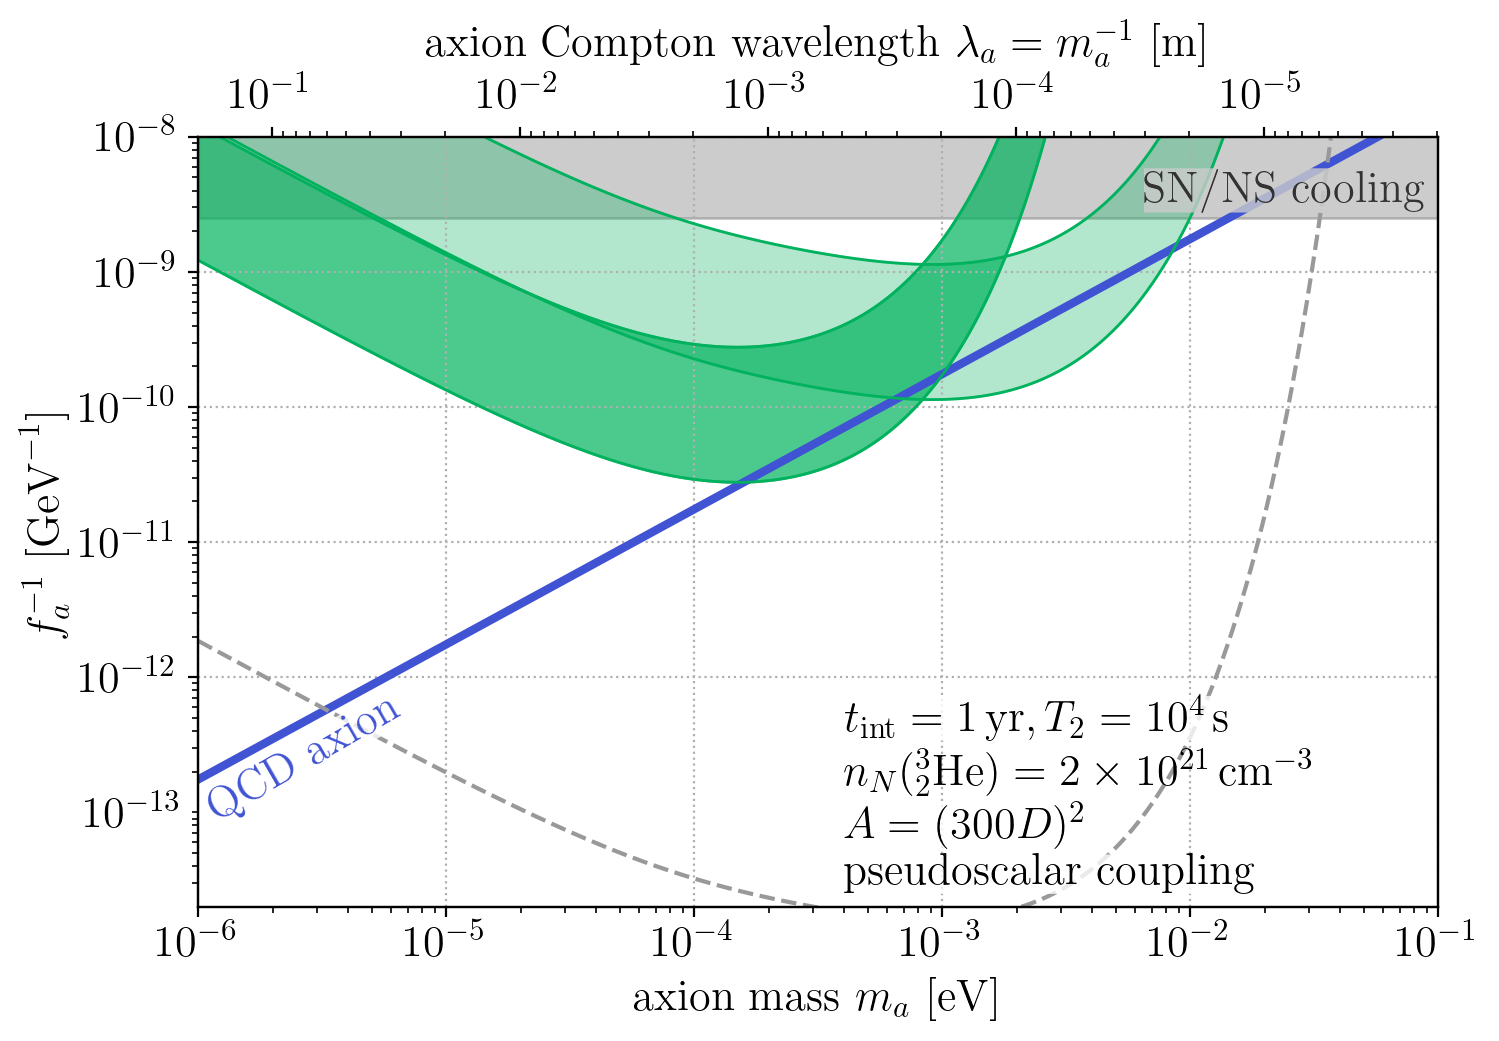

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-6,1e-1); ax.set_ylim(2e-14,1e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$',fontsize=16); ax_top.set_xlabel('axion Compton wavelength $\lambda_a = m_a^{-1}~[\mathrm{m}]$',fontsize=16, va='bottom'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$',fontsize=16);
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_left_minor[(ax.get_ylim()[0] < ticks_left_minor) & (ticks_left_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-12,-7.99))
ticks_top_minor = (np.outer(10**(np.arange(2.0,-6.01,-1)),np.arange(1.,10.,1.)).flatten() * meter)**-1 / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = (10**(np.arange(-1.,-5.01,-1)) * meter)**-1 / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major,minor=False); 
ax.grid(ls='dotted',which='major',axis='both')
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True);
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$','$10^{-5}$'],minor=False);
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=ncolors[0],lw=3);
ax.fill_between(vec_ma/eV,fa_SN_bound**-1 * GeV,1e-5,color=(0,0,0,0.2))
ax.tick_params(axis='both', which='both', labelsize=16)
ax_top.tick_params(axis='both', which='both', labelsize=16)

y_values_1 = []
y_values_2 = []
alphas = [0.3, 0.7]

for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    y1 = GeV * np.sqrt(fn_fa_2_inv_sens_dip(vec_ma, D, h, Eu.n_N, P_nuc, c_aNN, T_2, n_N_det, vol))
    y_values_1.append(y1)
    ax.plot(vec_ma / eV, y1, lw=1, color=ncolors[5], label=vec_label[i_D] + ', dipole' + ', $c_N=1$')

for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    y2 = GeV * np.sqrt(fn_fa_2_inv_sens_dip(vec_ma, D, h, Eu.n_N, P_nuc, c_aNN2, T_2, n_N_det, vol))
    y_values_2.append(y2)
    ax.plot(vec_ma / eV, y2, lw=1, color=ncolors[5], label=vec_label[i_D] + ', dipole' + ', $c_N=0.1$')

for i_D in range(len(vec_D)):
     ax.fill_between(vec_ma / eV, y_values_1[i_D], y_values_2[i_D], color=ncolors[5], alpha=alphas[i_D])


ax.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_dip_SQUID(vec_ma,vec_D[0],h, Eu.n_N, P_nuc, c_aNN2, T_2, n_N_det, vol)),
               color=(0.6, 0.6, 0.6), label=vec_label[0]+', SQUID limit', linestyle='dashed')

ax.text(7e-6,8.5e-13,'QCD axion',ha='right',va='top',color=ncolors[0],rotation=30,fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(9e-2,1.1 * fa_SN_bound**-1 * GeV,'SN/NS cooling',ha='right',va='bottom',color=(0.2,0.2,0.2),rotation=0,fontsize=16,
        bbox=dict(facecolor=(0.8,0.8,0.8,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(4.6)*3e-14,r'$t_\mathrm{int} = 1\,\mathrm{yr}, T_2 = 10^4\,\mathrm{s}$',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(3.3)*3e-14,r'$n_N({{}^{3}_2\mathrm{He}}) = 2 \times 10^{21} \, \mathrm{cm}^{-3}$',va='top',fontsize=16)
ax.text(0.4e-3,2**(2.0)*3e-14,r'$A = (300 D)^2$',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(0.7)*3e-14,r'pseudoscalar coupling',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
#ax.text(0.8e-2,2**(1)*1e-12,r'${}^{235}_{92}\mathrm{U}$ source mass',va='top',  fontsize=16)

#handles, labels = plt.gca().get_legend_handles_labels()
#order = [0,1,2,3]
#legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=12,loc='upper left', ncol=2, framealpha=1.0);

file_path = dir_fig + "dipole-dipole.pdf"
plt.savefig(file_path,bbox_inches='tight', pad_inches=0)

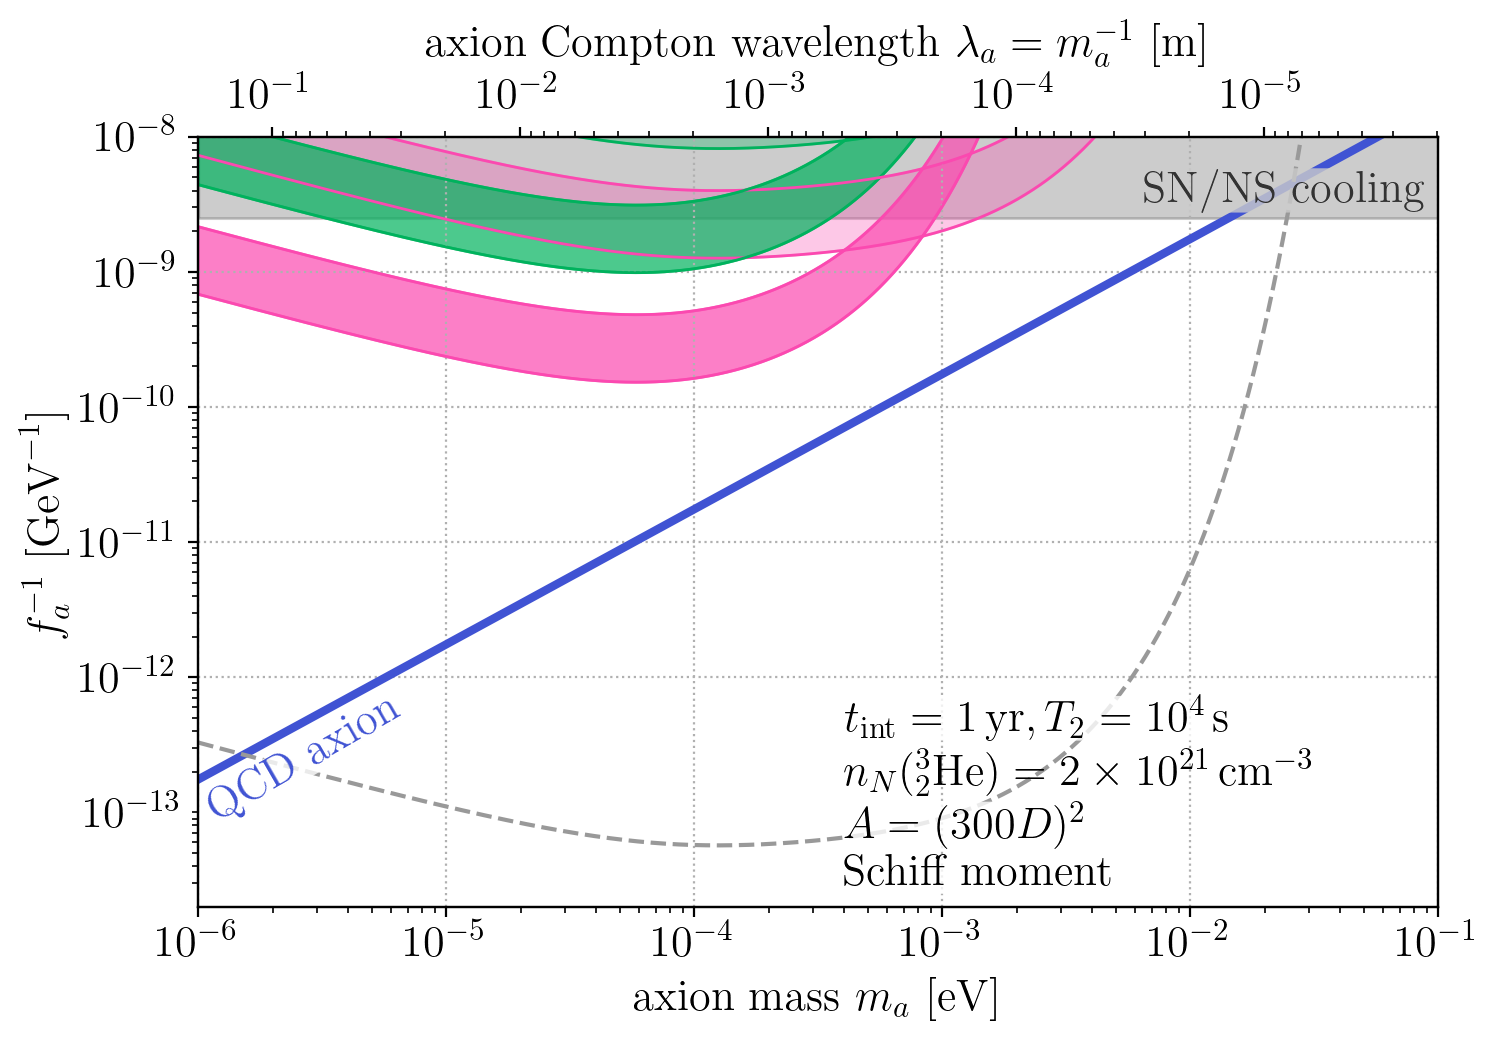

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-6,1e-1); ax.set_ylim(2e-14,1e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$',fontsize=16); ax_top.set_xlabel('axion Compton wavelength $\lambda_a = m_a^{-1}~[\mathrm{m}]$',fontsize=16, va='bottom'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$',fontsize=16);
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_left_minor[(ax.get_ylim()[0] < ticks_left_minor) & (ticks_left_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-12,-7.99))
ticks_top_minor = (np.outer(10**(np.arange(2.0,-6.01,-1)),np.arange(1.,10.,1.)).flatten() * meter)**-1 / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = (10**(np.arange(-1.,-5.01,-1)) * meter)**-1 / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major,minor=False); 
ax.grid(ls='dotted',which='major',axis='both')
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True);
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$','$10^{-5}$'],minor=False);
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=ncolors[0],lw=3);
ax.fill_between(vec_ma/eV,fa_SN_bound**-1 * GeV,1e-5,color=(0,0,0,0.2))
ax.tick_params(axis='both', which='both', labelsize=16)
ax_top.tick_params(axis='both', which='both', labelsize=16)

y_values_Eu_1 = []
y_values_Np_1 = []
y_values_Eu_2 = []
y_values_Np_2 = []

alphas = [0.3, 0.7]

for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    y1_Np = GeV*np.sqrt(fn_fa_2_inv_sens_mon(vec_ma,D,h,Np.rho_s[1],P_nuc,c_aNN,T_2,n_N_det,vol))
    y1_Eu = GeV*np.sqrt(fn_fa_2_inv_sens_mon(vec_ma,D,h,Eu.rho_s[1],P_nuc,c_aNN,T_2,n_N_det,vol))
    y_values_Np_1.append(y1_Np)
    y_values_Eu_1.append(y1_Eu)
    
    ax.plot(vec_ma/eV,y1_Np,
             lw=1,color=ncolors[4],label=vec_label[i_D]+', $Np_3OF_{12}$')
    ax.plot(vec_ma/eV,y1_Eu,
             lw=1,color=ncolors[5],label=vec_label[i_D]+', $Eu_{0.5}Ba_{0.5}TiO_3$')
    
for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    y2_Np = GeV*np.sqrt(fn_fa_2_inv_sens_mon(vec_ma,D,h,Np.rho_s[1],P_nuc,c_aNN2,T_2,n_N_det,vol))
    y2_Eu = GeV*np.sqrt(fn_fa_2_inv_sens_mon(vec_ma,D,h,Eu.rho_s[1],P_nuc,c_aNN2,T_2,n_N_det,vol))
    y_values_Np_2.append(y2_Np)
    y_values_Eu_2.append(y2_Eu)

    ax.plot(vec_ma/eV,y2_Np,
             lw=1,color=ncolors[4],label=vec_label[i_D]+', $Np_3OF_{12}$')
    ax.plot(vec_ma/eV,y2_Eu,
             lw=1,color=ncolors[5],label=vec_label[i_D]+', $Eu_{0.5}Ba_{0.5}TiO_3$')

for i_D in range(len(vec_D)):
    ax.fill_between(vec_ma / eV, y_values_Np_1[i_D], y_values_Np_2[i_D], color=ncolors[4], alpha=alphas[i_D])
    ax.fill_between(vec_ma / eV, y_values_Eu_1[i_D], y_values_Eu_2[i_D], color=ncolors[5], alpha=alphas[i_D])


ax.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_mon_SQUID(vec_ma,vec_D[0],h,Np.rho_s[1],P_nuc,c_aNN2,T_2,n_N_det,vol)),
               color=(0.6, 0.6, 0.6), label=vec_label[0]+', SQUID limit', linestyle='dashed')
ax.text(7e-6,8.5e-13,'QCD axion',ha='right',va='top',color=ncolors[0],rotation=30,fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(9e-2,1.1*fa_SN_bound**-1 * GeV,'SN/NS cooling',ha='right',va='bottom',color=(0.2,0.2,0.2),rotation=0,fontsize=16,
        bbox=dict(facecolor=(0.8,0.8,0.8,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(4.6)*3e-14,r'$t_\mathrm{int} = 1\,\mathrm{yr}, T_2 = 10^4\,\mathrm{s}$',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(3.3)*3e-14,r'$n_N({{}^{3}_2\mathrm{He}}) = 2 \times 10^{21} \, \mathrm{cm}^{-3}$',va='top',fontsize=16)
ax.text(0.4e-3,2**(2.0)*3e-14,r'$A = (300 D)^2$',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(0.7)*3e-14,r'Schiff moment',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));

#handles, labels = plt.gca().get_legend_handles_labels()
#order = [1,0,4,3,2]
#legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=12,loc='upper left', ncol=2, framealpha=1.0);

file_path = dir_fig + "schiff-dipole.pdf"
plt.savefig(file_path,bbox_inches='tight', pad_inches=0)

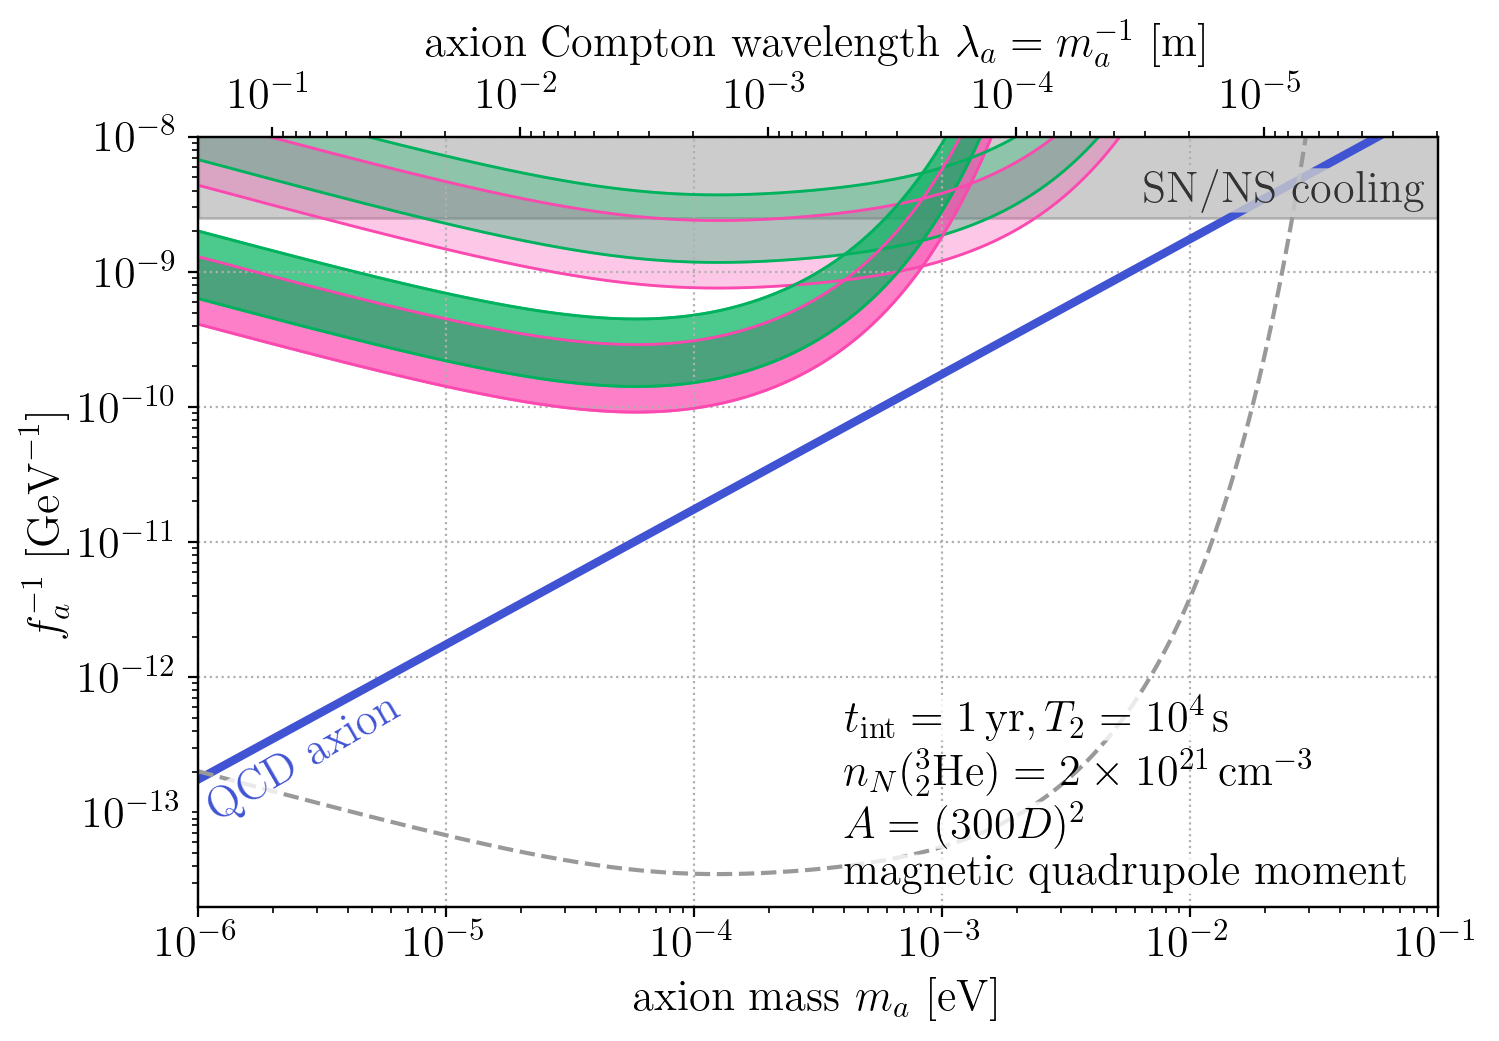

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-6,1e-1); ax.set_ylim(2e-14,1e-8)
ax_top = ax.twiny();  ax_top.set_xlim(ax.get_xlim()); ax_top.set_xscale('log');
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.set_xlabel(r'axion mass $m_a~[\mathrm{eV}]$',fontsize=16); ax_top.set_xlabel('axion Compton wavelength $\lambda_a = m_a^{-1}~[\mathrm{m}]$',fontsize=16, va='bottom'); ax.set_ylabel('$f_a^{-1}~[\mathrm{GeV}^{-1}]$',fontsize=16);
ticks_left_minor = np.outer(10**(np.arange(-19.0,-5)),np.arange(1.,10.,1.)).flatten()
ticks_left_minor = ticks_left_minor[(ax.get_ylim()[0] < ticks_left_minor) & (ticks_left_minor < ax.get_ylim()[1])]
ticks_left_major = 10**(np.arange(-12,-7.99))
ticks_top_minor = (np.outer(10**(np.arange(2.0,-6.01,-1)),np.arange(1.,10.,1.)).flatten() * meter)**-1 / eV; 
ticks_top_minor = ticks_top_minor[(ax_top.get_xlim()[0] < ticks_top_minor) & (ticks_top_minor < ax_top.get_xlim()[1])]
ticks_top_major = (10**(np.arange(-1.,-5.01,-1)) * meter)**-1 / eV
ax.set_yticks(ticks_left_minor,minor=True); ax.set_yticks(ticks_left_major,minor=False); 
ax.grid(ls='dotted',which='major',axis='both')
ax_top.set_xticks([],minor=True); ax_top.set_xticks(ticks_top_minor,minor=True); ax_top.set_xticklabels([],minor=True);
ax_top.set_xticks(ticks_top_major,minor=False); ax_top.set_xticklabels(['$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$','$10^{-5}$'],minor=False);
ax.plot(vec_ma/eV,1/fn_fa(vec_ma)*GeV,color=ncolors[0],lw=3); #QCD axion
ax.fill_between(vec_ma/eV,fa_SN_bound**-1 * GeV,1e-5,color=(0,0,0,0.2)) #SN cooling
ax.tick_params(axis='both', which='both', labelsize=16)
ax_top.tick_params(axis='both', which='both', labelsize=16)

y_values_Eu_1 = []
y_values_Np_1 = []
y_values_Eu_2 = []
y_values_Np_2 = []

alphas = [0.3, 0.7]

for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    y1_Np = GeV*np.sqrt(fn_fa_2_inv_sens_mon_mqm(vec_ma,D,h,Np.rho_m[1],c_aNN,T_2,Np.n_N,vol))
    y1_Eu = GeV*np.sqrt(fn_fa_2_inv_sens_mon_mqm(vec_ma,D,h,Eu.rho_m[1],c_aNN,T_2,Np.n_N,vol))
    y_values_Np_1.append(y1_Np)
    y_values_Eu_1.append(y1_Eu)
    
    ax.plot(vec_ma/eV,y1_Np,
             lw=1,color=ncolors[4],label=vec_label[i_D]+', $Np_3OF_{12}$')
    ax.plot(vec_ma/eV,y1_Eu,
             lw=1,color=ncolors[5],label=vec_label[i_D]+', $Eu_{0.5}Ba_{0.5}TiO_3$')
    
for i_D, D in enumerate(vec_D):
    vol = D**3 * vec_aspect[i_D]**2
    y2_Np = GeV*np.sqrt(fn_fa_2_inv_sens_mon_mqm(vec_ma,D,h,Np.rho_m[1],c_aNN2,T_2,Np.n_N,vol))
    y2_Eu = GeV*np.sqrt(fn_fa_2_inv_sens_mon_mqm(vec_ma,D,h,Eu.rho_m[1],c_aNN2,T_2,Np.n_N,vol))
    y_values_Np_2.append(y2_Np)
    y_values_Eu_2.append(y2_Eu)

    ax.plot(vec_ma/eV,y2_Np,
             lw=1,color=ncolors[4],label=vec_label[i_D]+', $Np_3OF_{12}$')
    ax.plot(vec_ma/eV,y2_Eu,
             lw=1,color=ncolors[5],label=vec_label[i_D]+', $Eu_{0.5}Ba_{0.5}TiO_3$')

for i_D in range(len(vec_D)):
    ax.fill_between(vec_ma / eV, y_values_Np_1[i_D], y_values_Np_2[i_D], color=ncolors[4], alpha=alphas[i_D])
    ax.fill_between(vec_ma / eV, y_values_Eu_1[i_D], y_values_Eu_2[i_D], color=ncolors[5], alpha=alphas[i_D])


ax.plot(vec_ma/eV,GeV*np.sqrt(fn_fa_2_inv_sens_mon_mqm_SQUID(vec_ma,vec_D[0],h,Np.rho_m[1],c_aNN2,T_2,Eu.n_N,vol)),
               color=(0.6, 0.6, 0.6), label=vec_label[0]+', SQUID limit', linestyle='dashed')
ax.text(7e-6,8.5e-13,'QCD axion',ha='right',va='top',color=ncolors[0],rotation=30,fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(9e-2,1.1*fa_SN_bound**-1 * GeV,'SN/NS cooling',ha='right',va='bottom',color=(0.2,0.2,0.2),rotation=0,fontsize=16,
        bbox=dict(facecolor=(0.8,0.8,0.8,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(4.6)*3e-14,r'$t_\mathrm{int} = 1\,\mathrm{yr}, T_2 = 10^4\,\mathrm{s}$',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(3.3)*3e-14,r'$n_N({{}^{3}_2\mathrm{He}}) = 2 \times 10^{21} \, \mathrm{cm}^{-3}$',va='top',fontsize=16)
ax.text(0.4e-3,2**(2.0)*3e-14,r'$A = (300 D)^2$',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));
ax.text(0.4e-3,2**(0.7)*3e-14,r'magnetic quadrupole moment',va='top',fontsize=16,
        bbox=dict(facecolor=(1,1,1,0.8), edgecolor='none', boxstyle='round,pad=0'));

#handles, labels = plt.gca().get_legend_handles_labels()
#order = [1,0,4,3,2]
#legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=12,loc='upper left', ncol=2, framealpha=1.0);

file_path = dir_fig + "mqm-dipole.pdf"
plt.savefig(file_path,bbox_inches='tight', pad_inches=0)